# timing test

Initially written in 2024A

edited and rerun in 2025A

In [184]:
import numpy as np
import spark_xrif as sx
import datetime
from astropy.io import fits
from matplotlib import pyplot as plt
from importlib import reload

In [185]:
reload(sx)

<module 'spark_xrif' from '/home/eden/code/testing/spark_xrif.py'>

In [186]:
# getting the right dark
dark_dir = '/opt/MagAOX/calib/camwfs-dark/'
# og set of data
#lab_dark = dark_dir + 'camwfs-dark_bin2_2000.000000_10.000000_-45.000000__T20240330051127513106835.fits'
# 5/25 set of data
lab_dark = dark_dir + 'camwfs-dark_bin2_2000.000000_1.000000_-45.000000__T20240402063434863230853.fits'

dark_data_lab = fits.open(lab_dark)[0].data

#np.save("darkdata.npy", dark_data_lab)

In [187]:
# getting mask data 
mask_data = fits.open(sx.glob_dir_calib + sx.glob_mask)[0].data
mask_nan = mask_data.copy()
mask_nan[mask_nan == 0] = np.nan

#np.save("mask.npy", mask_data)

## Pulling data, 

if you're smart about it, only have to do this one 

In [232]:
#delays = np.arange(50, 450+10, 10) #original delays
#delays = np.append(np.arange(50, 450+10, 50), [2,498]) # original delays + edge cases
delays = np.arange(5, 495+10, 10)
dwell = 100

In [233]:
# cycle thrugh all the dwell tests for a given sparkle param
sp_pttrn = 3
dt_start = datetime.datetime(2024, 5, 1, tzinfo=datetime.timezone.utc) 
all_data = []

for d in delays:
    obs_name = f"sparkles{sp_pttrn}_delay{d}_dwell100_amp02sep15_v2"

    # change name into span
    obs_span = sx.verify_obs(obs_name, dt_start)

    # pull the observation spans
    files = sx.gen_file_list(obs_span)

    # make the observation spans a file
    data, timing = sx.pull_n_files(files, n=1000, fsize=5250)

    # add to the big stack
    all_data.append(data)
data_array = np.array(all_data)


PULLING 1000 FILES
FILE no 1, n_start 0, n 1000, n_offset 0
XRIF index 0, no of files 1, len list 1
xrif compression details:
  difference method:  previous
  reorder method:     bytepack
  compression method: LZ4
    LZ4 acceleration: 1
  dimensions:         120 x 120 x 1 x 8192
  raw size:           235929600 bytes
  encoded size:       118924643 bytes
  ratio:              0.504

xrif compression details:
  difference method:  none
  reorder method:     none
  compression method: none
  dimensions:         5 x 1 x 1 x 8192
  raw size:           327680 bytes
  encoded size:       327680 bytes
  ratio:              1.000

   => actual shape (8192, 120, 120)
   => index at 1000
file n pull (1000, 120, 120)
PULLING 1000 FILES
FILE no 1, n_start 0, n 1000, n_offset 0
XRIF index 0, no of files 1, len list 1
xrif compression details:
  difference method:  previous
  reorder method:     bytepack
  compression method: LZ4
    LZ4 acceleration: 1
  dimensions:         120 x 120 x 1 x 7805
  r

In [234]:
#want to take all the data raw and subtract the 
data_darksub = data_array - dark_data_lab
# now normalize by the mask 
data_normed = np.divide(data_darksub*mask_data, np.sum(data_darksub*mask_data)) 

In [ ]:
np.save(f"spark_t_test/sparkle_{sp_pttrn}_data_normed.npy", data_normed)

## Using data, once it's saved

skip to this step if you already did all the hard work 


In [235]:
spkl_pttrn = 3

In [ ]:
# as a quick fix, I'm going to resave this data with 
spkl_pttrn = 2
data_raw = np.load(f"spark_t_test/sparkle_{spkl_pttrn}_data.npy")
data_normed = np.load(f"spark_t_test/sparkle_{spkl_pttrn}_data_normed.npy")

In [236]:
data_normed.shape

(50, 1000, 120, 120)

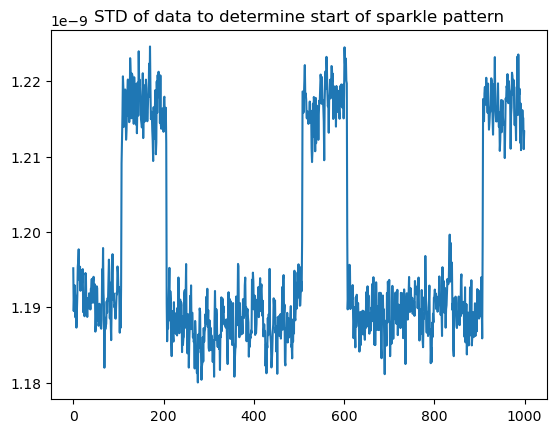

In [237]:
plt.title("STD of data to determine start of sparkle pattern")
plt.plot(np.std(data_normed, axis=(2,3))[0])

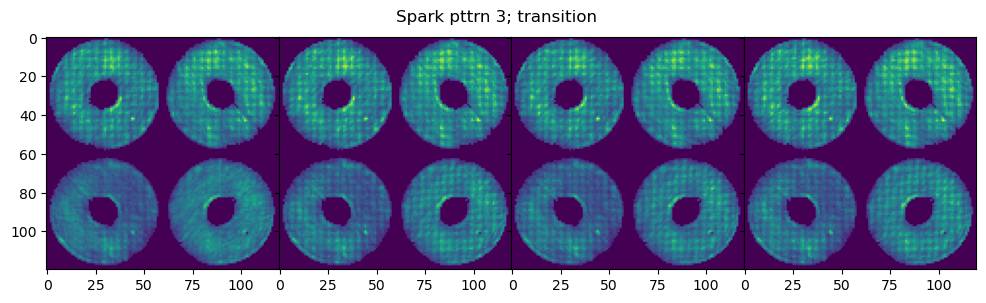

In [243]:
# STEP 1 : find the sparkles
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,7), facecolor='white', sharey=True, sharex=True)
fig.subplots_adjust(wspace=0, hspace=0)

mask = mask_nan
trans_delay = 0 # just use the starting delay
# CHANGE THIS!!! IMPORTANT TO START
trans_frame = 107

for e in range(4):
    axs[e].imshow( data_normed[trans_delay,trans_frame+e])

plt.suptitle(f"Spark pttrn {spkl_pttrn}; transition",y=0.7)
plt.show()

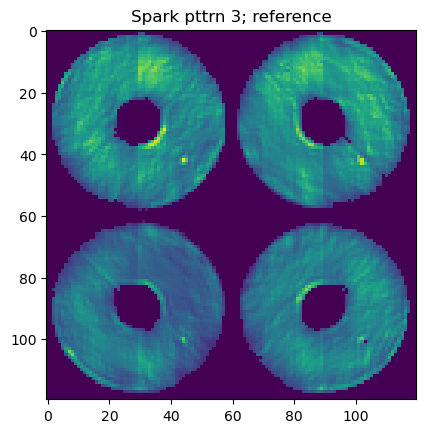

In [244]:
# STEP 2: make a reference
ref_homemade = np.average(data_normed[trans_delay, (trans_frame+120) : (trans_frame + 380)], axis=(0))
plt.title(f"Spark pttrn {spkl_pttrn}; reference")

plt.imshow(ref_homemade)

In [245]:
# STEP 3: clean up data normed with a subtraction of a self-made referece. 
data_norm_sub = data_normed - ref_homemade

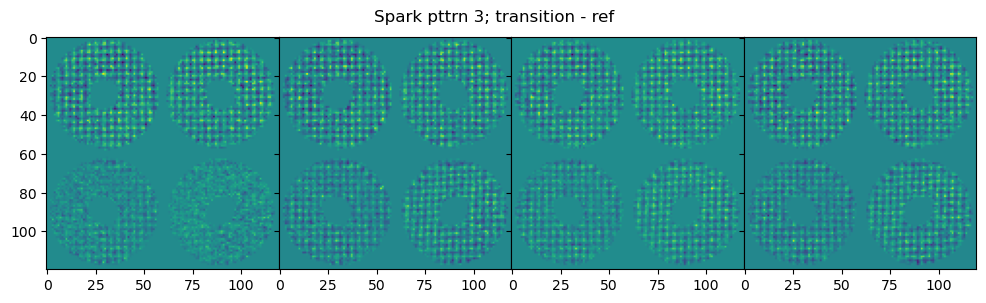

In [246]:
# STEP 4: recheck that transition with the reference:

# checking the lab reference: 
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,7), facecolor='white', sharey=True, sharex=True)
fig.subplots_adjust(wspace=0, hspace=0)

mask = mask_nan

for e in range(4):
    axs[e].imshow( data_norm_sub[trans_delay, trans_frame+e])

plt.suptitle(f"Spark pttrn {spkl_pttrn}; transition - ref ",y=0.7)
plt.show()

Text(0.5, 1.0, 'Spark pttrn 3; sparkle reference')

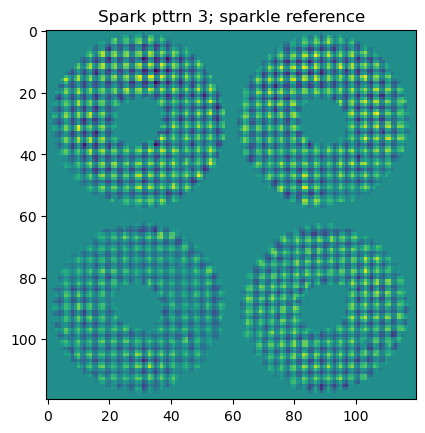

In [247]:
# STEP 5: build a sparkle reference from known good frames
spark_pttrn_0 = np.average(data_norm_sub[trans_delay, trans_frame + 5 : trans_frame + 90], axis=(0))
plt.imshow(spark_pttrn_0)
plt.title(f"Spark pttrn {spkl_pttrn}; sparkle reference")

In [248]:
# STEP 6:  now take that and dot product it across all the other files. 
dot_spkl_data = np.nansum(spark_pttrn_0*data_norm_sub, axis=(2,3))

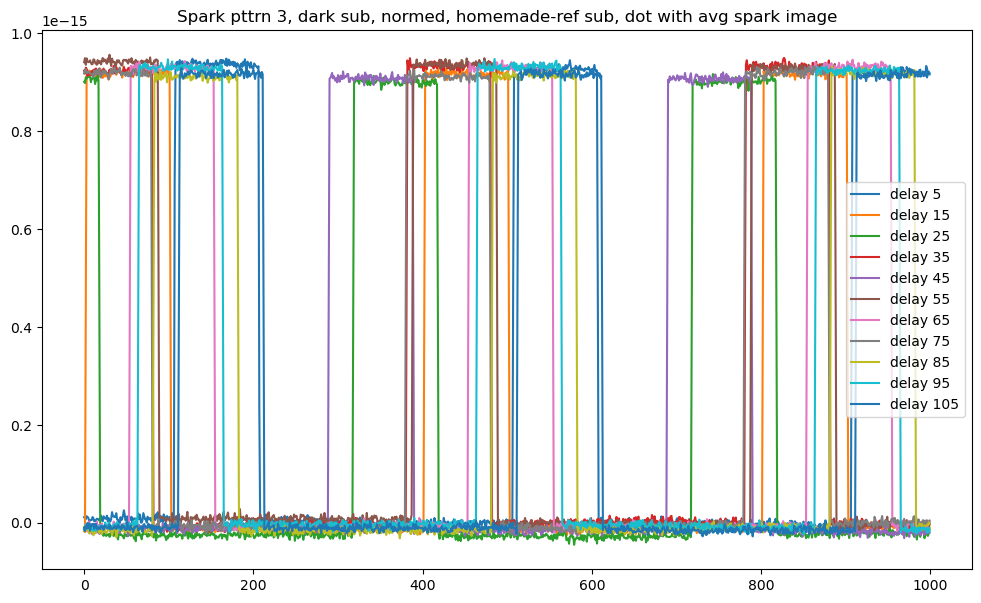

In [250]:
# STEP 6 PLOT: at this point, the sparkles are not aligned. 
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,7), facecolor='white', sharey=True, sharex=True)

for e in range(11):
    plt.plot(dot_spkl_data[e, :1000], label=f'delay {delays[e]}')
plt.legend()
plt.title(f'Spark pttrn {spkl_pttrn}, dark sub, normed, homemade-ref sub, dot with avg spark image')
plt.plot()
plt.show()

In [251]:
# STEP 7: ok so now we want to find the first max in the array that gt 1e-15 => roll to that index
spark_dot_diff = np.diff(dot_spkl_data)

spark_dot_diff_norm = np.divide(spark_dot_diff.T, np.max(spark_dot_diff, axis=1)).T
roll_idx = np.argmax(spark_dot_diff_norm[:, 0:400]>0.1, axis=(1))

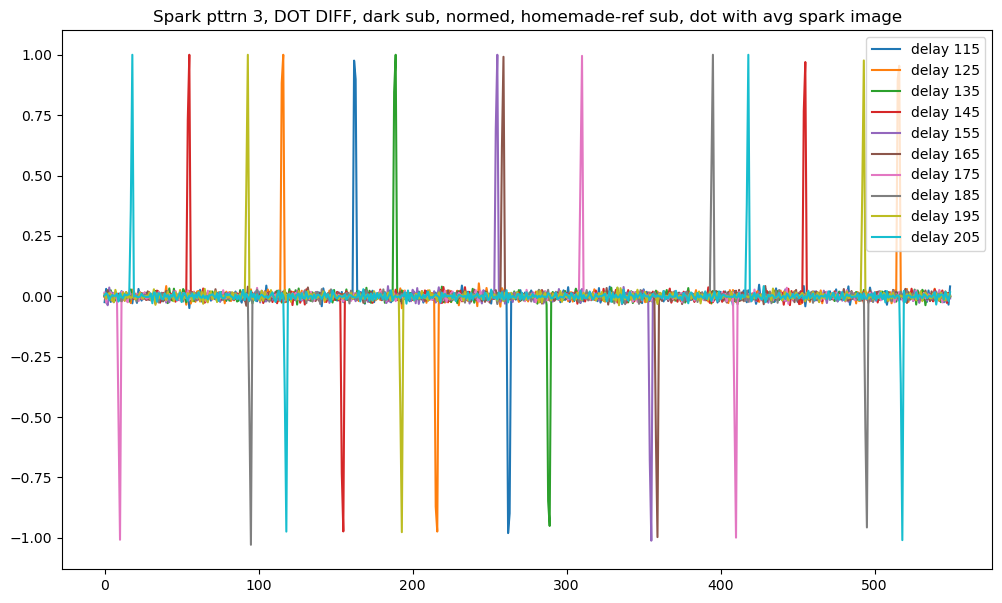

In [252]:
# STEP 7 PLOT: checking the Dif Sub
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,7), facecolor='white', sharey=True, sharex=True)

plt.title(f'Spark pttrn {spkl_pttrn}, DOT DIFF, dark sub, normed, homemade-ref sub, dot with avg spark image')

#for e in range(5):
#    plt.plot(spark_dot_diff_norm[e, 0:400], label=f'delay {10*e +50}')

for e in range(11,21):
    plt.plot(spark_dot_diff_norm[e, :550], label=f'delay {delays[e]}')


plt.legend()
plt.show()

In [253]:
#STEP *: roll o
dot_spkl_data_roll = np.array([np.roll(dot_spkl_data[e], - roll_idx[e]) for e in range(len(delays))])

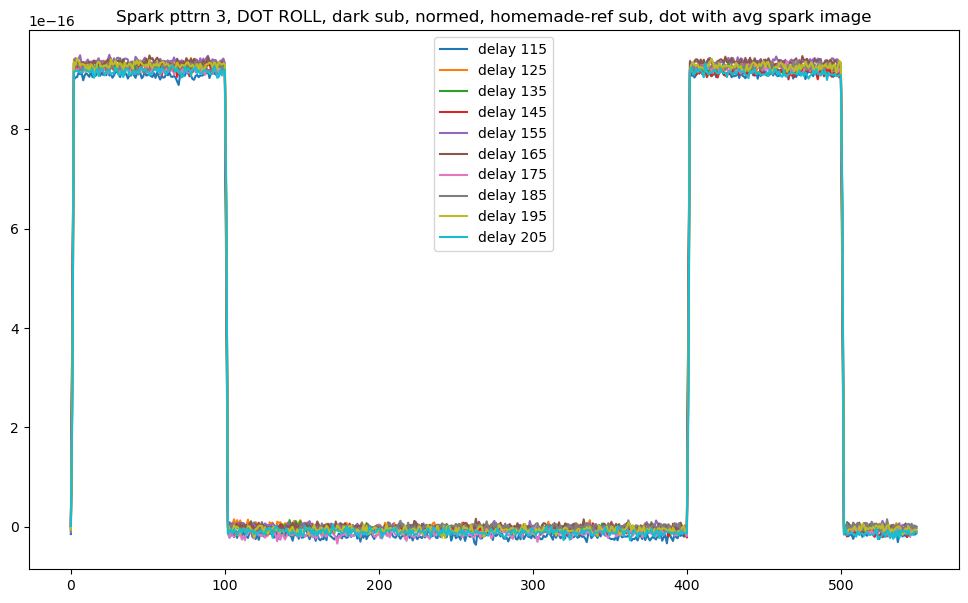

In [254]:
# STEP 8: Now roll to these max differences indexs
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,7), facecolor='white', sharey=True, sharex=True)

plt.title(f'Spark pttrn {spkl_pttrn}, DOT ROLL, dark sub, normed, homemade-ref sub, dot with avg spark image')

for e in range(11,21):
    plt.plot(dot_spkl_data_roll[e, :550], label=f'delay {delays[e]}')

plt.legend()
plt.show()

In [255]:
# EDIT THIS: based on the above plot
trans_start = 399 #398
trans_end = 404 #405

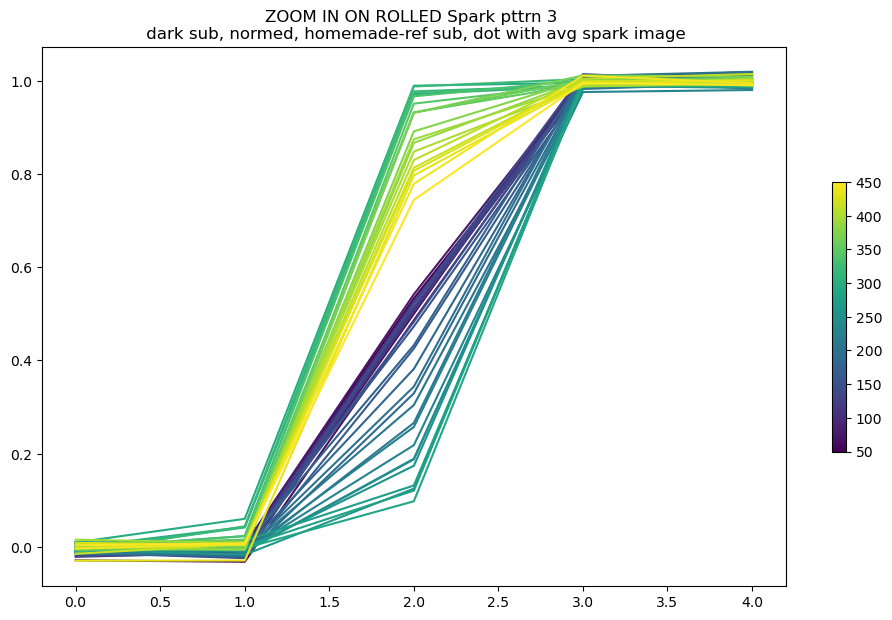

In [256]:
# STEP 9: compare at the transition region
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

viridis = mpl.pyplot.colormaps.get_cmap('viridis')
colors = viridis(np.linspace(0,1,len(delays)))

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,7), facecolor='white', sharey=True, sharex=True)

for e in range(len(delays)):
    plt.plot(dot_spkl_data_roll[e, trans_start:trans_end] / dot_spkl_data_roll[e, trans_end], label=f'delay {10*e +50}', c = colors[e])

plt.title(f'ZOOM IN ON ROLLED Spark pttrn {spkl_pttrn} \n dark sub, normed, homemade-ref sub, dot with avg spark image')

ax, _ = mpl.colorbar.make_axes(plt.gca(), shrink=0.5)
cbar = mpl.colorbar.ColorbarBase(ax, cmap=viridis, norm=mpl.colors.Normalize(vmin=50, vmax=450))


In [257]:
# STEP 10: pull out these transtion values 
dot_spkl_data_roll_T = dot_spkl_data_roll.T

transition = np.array([dot_spkl_data_roll_T[1+ 400*e] / dot_spkl_data_roll_T[5+ 400*e]  for e in range(1000//400)])

In [258]:
# theoretical percentages
#delays = np.arange(50,450+10, 10)
ratio_thry = [1 - (d + 50)/500 for d in delays]

[]

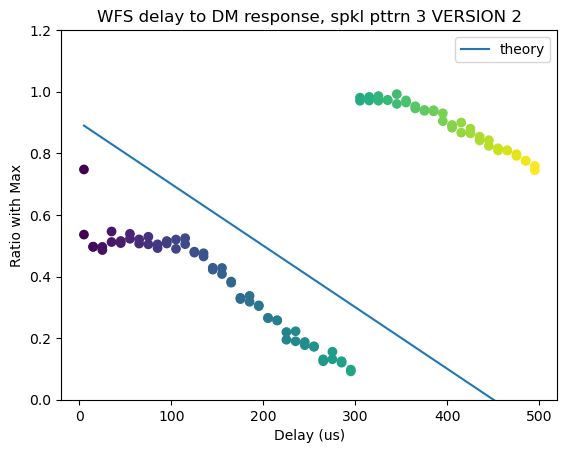

In [259]:
plt.plot(delays, ratio_thry, label="theory", ls='--', label="theory", c ='grey')

for e in range(1000//400):
    plt.scatter(delays, transition[e], c=delays, cmap='viridis')

plt.legend()
plt.ylabel("Ratio with Max")
plt.xlabel("Delay (us)")
plt.title(f"WFS delay to DM response, spkl pttrn {spkl_pttrn} VERSION 2")
plt.ylim(0, 1.2)
plt.plot()


In [ ]:
np.save(f"spark_t_test/sparkle_{sp_pttrn}_transition.npy", transition)

### Delay shift us

do this across all sparkle patterns

In [ ]:
transitions_list = []
for i in range(4):
    transitions_list.append(np.load(f"spark_t_test/sparkle_{i}_transition.npy"))

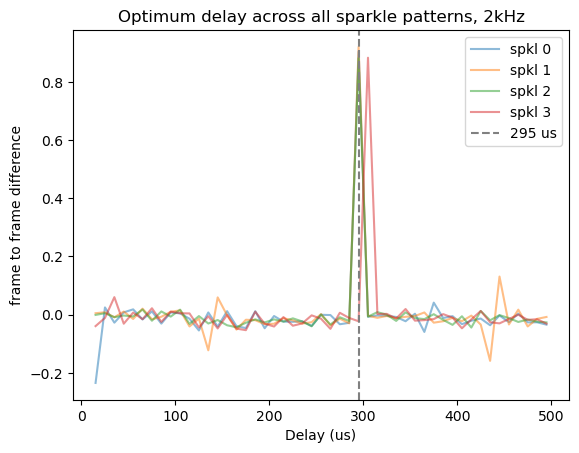

In [272]:
#When do we switch?
plt.title("Optimum delay across all sparkle patterns, 2kHz")

for i in range(4):
    plt.plot(delays[1:], np.diff(transitions_list[i][1]), alpha = 0.5, label=f'spkl {i}')

max_shift = np.argmax(transitions_list[0][1])*10+5
plt.axvline(max_shift, ls="--", label = f"{max_shift} us", c='grey')

plt.ylabel("frame to frame difference")
plt.xlabel("Delay (us)")

plt.legend()
plt.show()

In [298]:
# fitting the transitions: cut after the plateau 
transition = np.mean(np.array(transitions_list)[:, :, 11:29], axis=(0,1))
delays_trans = delays[11:29]

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(delays_trans,transition)

x_fit = lambda x: x*slope + intercept
y_fit = lambda y: (y-intercept)/slope


In [293]:
# fitting the plateau
plateau = np.mean(np.array(transitions_list)[:, :, 1:11], axis=(0,1))
delays_p = delays[1:11]

np.mean(plateau)

0.5022136

In [304]:
# cycling the fit properly
min_val = np.min(transitions_list)

delay_fit = ((x_fit(delays) - min_val)%1) + min_val

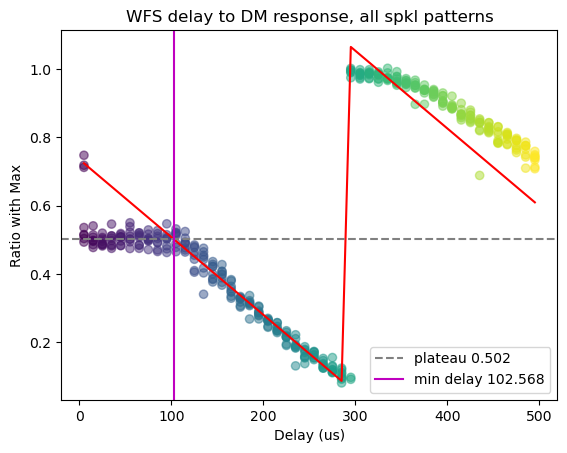

In [305]:
plt.title(f"WFS delay to DM response, all spkl patterns")

for i in range(4):
    for e in range(2):
        plt.scatter(delays, transitions_list[i][e], c=delays, cmap='viridis', alpha=0.5)

plt.plot(delays, delay_fit, c='r')
plt.axhline(np.mean(plateau), label=f'plateau {np.mean(plateau):0.3f}', c='grey', ls="--")
min_delay = y_fit(np.mean(plateau))
plt.axvline(min_delay, label=f'min delay {min_delay:0.3f}', c='m')

plt.ylabel("Ratio with Max")
plt.xlabel("Delay (us)")
plt.legend()
plt.show()